In [1]:
%run Runge_Kutta.ipynb

<IPython.core.display.Javascript object>

# Lorenz Strange Attractor
---
In 1963, Edward Lorenz developed a simplified mathematical model for [atmospheric convection](https://en.wikipedia.org/wiki/Lorenz_system). The model is a system of three ordinary differential equations now known as the Lorenz equation

\begin{equation}
\begin{split}
\dot{x} & = \sigma (y - x) \\
\dot{y} & = x(\rho - z) - y \\
\dot{z} & = xy - \beta z \\
\end{split}
\end{equation}

The equations relate the properties of a two-dimensional fluid layer uniformly warmed from below and cooled from above. In particular, the equations describe the rate of change of three quantities with respect to time: $x$ is proportional to the rate of convection, $y$ to the horizontal temperature variation, and $z$ to the vertical temperature variation. The constants $\sigma$ ,$\rho$, and $\beta$ are system parameters proportional to the Prandtl number, Rayleigh number, and certain physical dimensions of the layer itself.

In [2]:
def solve_lorenz(N, T, dt):
    
    # Generate random intial conditions
    L0 = -10 + 20 * np.random.random((N, 3))
    
    # time array
    t_points = np.arange(0, (T+dt), dt)
    
    # Define the Lorenz system, using the same syntax as ODEint()
    def lorenz(t, X, sigma=10, beta=8/3, rho=28):
        """The Lorenz equations."""
        x, y, z = X
        dxdt = sigma*(y - x)
        dydt = -x * z + rho * x - y
        dzdt = x * y - beta * z
        return np.array([dxdt, dydt, dzdt])
    
    # get the different lines from the viridis colormap
    colors = plt.cm.viridis(np.linspace(0, 1, N))
    
    fig = plt.figure(figsize=(12, 8))
    for n in range(N):
        # Runge Kutta 3 solve
        solver = RungeKutta3(lorenz)
        
        # initialise
        solver.set_initial_condition(L0[n])
        
        # solve
        t, q = solver.solve(t_points)
        x, y, z = q.T
        ax = fig.gca(projection='3d')
        ax.plot(x, y, z, color=colors[n])

    ax.set_axis_off()
    ax.view_init(10, 100)

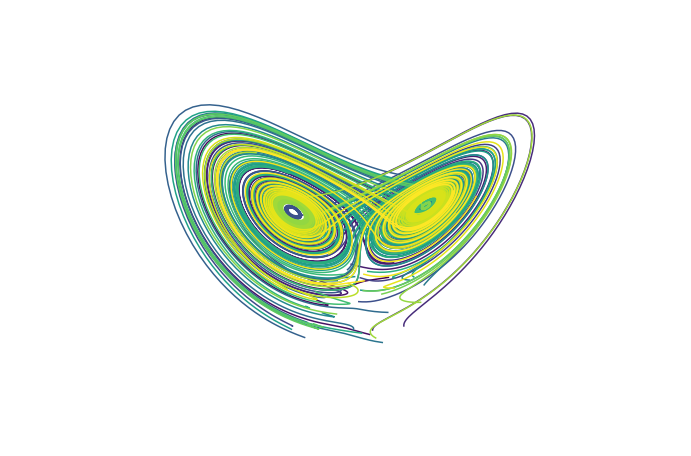

In [3]:
solve_lorenz(N=50, T=6, dt=0.005)

In [4]:
def animate_lorenz(N, T, dt, sigma=10, beta=8/3, rho=28, every=10):
    """
    Animate the Lorenz strange attractor for N trajectories. 
    Default coefficients produce the system where the strange
    attractors can be observed.
    """

    def lorenz(t, X, sigma=sigma, beta=beta, rho=rho):
        """The Lorenz equations."""
        x, y, z = X
        dxdt = sigma*(y - x)
        dydt = -x * z + rho * x - y
        dzdt = x * y - beta * z
        return np.array([dxdt, dydt, dzdt])

    # intial conditions and array to store results
    L0 = -15 + 30 * np.random.random((N, 3))
    t_points = np.arange(0, (T+dt), dt)
    q = np.zeros((N, len(t_points), 3))
    
    # solve
    for n in range(N):
        solver = RungeKutta3(lorenz)
        solver.set_initial_condition(L0[n])
        t, q[n, :, :] = solver.solve(t_points)

    # Set up figure & 3D axis for animation
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_axes([0, 0, 1, 1], projection='3d')
    ax.axis('off')

    # choose a different color for each trajectory (from viridis)
    colors = plt.cm.viridis(np.linspace(0, 1, N))

    # set up lines and points
    lines = sum([ax.plot([], [], [], '-', c=c) for c in colors], [])
    pts = sum([ax.plot([], [], [], 'o', markersize=6, c=c) for c in colors], [])

    # prepare the axes limits
    ax.set_xlim((-25, 25))
    ax.set_ylim((-35, 35))
    ax.set_zlim((5, 55))
    ax.view_init(0, 100)
    plt.close()
    
    # initialization function: plot the background of each frame
    def init():
        for line, pt in zip(lines, pts):
            line.set_data([], [])
            line.set_3d_properties([])
            pt.set_data([], [])
            pt.set_3d_properties([])
        return lines + pts

    def animate(i):
        # step every "every" time-steps per frame.
        i = (every * i) % q.shape[1]
        for line, pt, qi in zip(lines, pts, q):
            x, y, z = qi[:i].T
            line.set_data(x, y)
            line.set_3d_properties(z)
            pt.set_data(x[-1:], y[-1:])
            pt.set_3d_properties(z[-1:])
        ax.view_init(0.025 * i, 100 + 0.025 * i)
        fig.canvas.draw()
        return lines + pts
    
    frames = int(T / dt / every)

    return animation.FuncAnimation(fig, animate, init_func=init, frames=frames, interval=30, blit=True)

In [5]:
anim = animate_lorenz(N=10, T=8, dt=0.005, sigma=10, beta=8/3, rho=28, every=5)

In [ ]:
HTML(anim.to_jshtml())

The system is known to be be extremely sensitive to the initial conditions imposed [1](https://www.cambridge.org/core/books/turbulent-flows/C58EFF59AF9B81AE6CFAC9ED16486B3A). To investigate this, two trajectories with initial conditions [0.1, 0.1, 0.1] and [0.100001, 0.1, 0.1].

In [6]:
def sensitivity(T, dt):
    # time interval to solve
    t_points = np.arange(0, (T+dt), dt)
    
    def lorenz(t, X, sigma=10, beta=8/3, rho=28,):
        """The Lorenz equations."""
        x, y, z = X
        dxdt = sigma*(y - x)
        dydt = -x * z + rho * x - y
        dzdt = x * y - beta * z
        return np.array([dxdt, dydt, dzdt])
    
    # intial conditions, only a tiny difference in one of the position
    L0 = np.array([[0.1,      0.1, 0.1],
                   [0.100001, 0.1, 0.1]])
    
    # array to store results
    q_s = np.zeros((len(t_points), 2, 3))
    
    # solve
    for i in range(2):
        solver = RungeKutta3(lorenz)
        solver.set_initial_condition(L0[i, :])
        t, q = solver.solve(t_points)
        q_s[:, i, :] = q
        
    return q_s, t

In [7]:
q, t = sensitivity(T=100, dt=0.01)

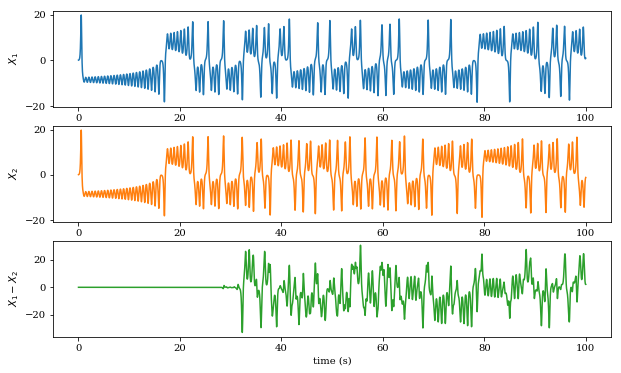

In [9]:
plt.figure(figsize=(10, 6))
ax1 = plt.subplot(311)
plt.plot(t, q[:, 0, 0], 'C0')
plt.ylabel(r"$X_1$")
ax2 = plt.subplot(312, sharex=ax1)
plt.plot(t, q[:, 1, 0], 'C1')
plt.ylabel(r"$X_2$")
ax3 = plt.subplot(313, sharex=ax1)
plt.plot(t, q[:, 0, 0] - q[:, 1, 0], 'C2')
plt.xlabel("time (s)"), plt.ylabel(r"$X_1 - X_2$")
plt.show();

Clearly, after $\sim35$ seconds the systems follow completely different paths.